# MLP

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mnist as mnist
from hgen import write_model, write_compressed_data_file

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

%matplotlib inline

Using TensorFlow backend.


In [2]:
from numpy.random import seed
from tensorflow import set_random_seed
seed(1)
set_random_seed(2)

In [3]:
# Reshape image data so each image is represented by one long array 
def prepare_input(arr):
    arr = arr.reshape(arr.shape[0], arr.shape[1] * arr.shape[2])
    
    # Convert to input float32
    arr = arr.astype('float32')

    # Normalise input in the range [-1, 1] 
    arr = (arr-127.5) / 127.5

    return arr

def mem_usage(numpy_arr):
    print('Uses {0:.2f} MB of memory'.format(numpy_arr.nbytes / 1024 / 1024))

def select_ten_digits(labels):
    image_indices = []
    for number in range(10):
        # Find indicies where elements equal to a specific number
        indices = np.where(labels == number)[0]
        rnd_idx = np.random.choice(indices, 1)[0]
        image_indices.append(rnd_idx)
    return image_indices

def plot_ten_digits(images, indices):
    num_rows = 2
    num_columns = 5
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(10, 3))
    for row in range(num_rows):
        for column in range(num_columns):
            img = images[indices[column + (row*num_columns)]]
            axes[row][column].imshow(img, cmap='binary')

In [4]:
X_original = mnist.train_images()
y_original = mnist.train_labels()
X_test_original = mnist.test_images()
y_test_original = mnist.test_labels()

---
## Visual data

In [5]:
ten_indices = select_ten_digits(y_test_original)
ten_indices

[443, 2013, 8707, 7130, 6488, 9478, 1676, 1260, 9967, 5622]

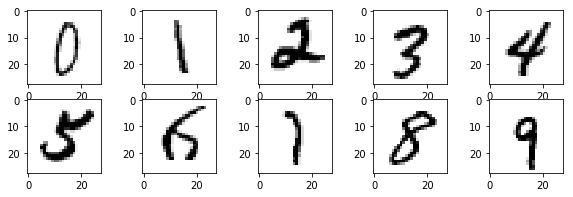

In [6]:
plot_ten_digits(X_test_original, ten_indices)

---
## Prepare Data

In [7]:
# Reshape and normalise input
X = prepare_input(X_original)
X_test = prepare_input(X_test_original)

---
## Export Data

In [37]:
# Generates a C-file that contains 10 randomly selected images.
inputs_to_export = X_test[ten_indices]
file_name = 'ten_digits.h'
f = open(file_name ,'w')

N = inputs_to_export.shape[0]
D = inputs_to_export.shape[1]
f.write('unsigned int n_input  = {};\n'.format(N))
f.write('unsigned int n_dimensions  = {};\n'.format(D))
f.write('float inputs[{}][{}] = {{\n'.format(N, D));
for i in range(N):
    if i > 0:
        f.write('  ,\n')
    f.write('  {{ // Image {}\n  '.format(i+1))
    for j in range(D):
        if j > 0:
            f.write(',')
        if (j+1) % 3 == 0:
            f.write('\n  ')
        f.write('{0:20}'.format(inputs_to_export[i][j]))
    f.write('\n  }} // Image {} \n'.format(i+1))
f.write('};\n')
f.close()

In [9]:
# N = 1000
# write_data_file(X_test[0:N,], y_test_original[0:N], 'test_data.csv')
write_compressed_data_file(X_test, y_test_original, 'gen/test_data.zip')

---
## Prepare for training

In [10]:
num_classes = np.unique(y_original).shape[0]
input_size = X.shape[1]

# Convert class vectors to binary class matrices
y = keras.utils.to_categorical(y_original, num_classes)
y_test = keras.utils.to_categorical(y_test_original, num_classes)

In [11]:
def train(model, model_name='model'):
    model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(momentum=0.9),
              metrics=['accuracy'])
    history = model.fit(X, y,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test))
    model.save_weights('models/{}.hdf5'.format(model_name))

In [12]:
from keras.layers import Input, Dense
from keras.models import Model

def create_mlp_3_layers_32():
    inputs = Input(shape=(input_size,))
    x = Dense(32, name='hidden', activation='relu')(inputs)
    predictions = Dense(10, name='output', activation='softmax')(x)
    model = Model(inputs=inputs, outputs=predictions)
    return { 'model': model, 'name': 'mpl_3_layers_32' }

mpl_3_layers_32 = create_mlp_3_layers_32()
mpl_3_layers_32_model = mpl_3_layers_32['model']
mpl_3_layers_32_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
hidden (Dense)               (None, 32)                25120     
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


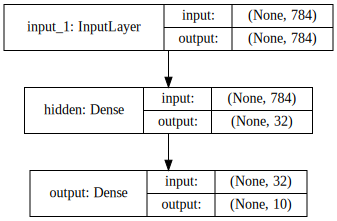

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(mpl_3_layers_32_model, show_shapes=True).create(prog='dot', format='svg'))

---
## Training

In [14]:
train(mpl_3_layers_32['model'], mpl_3_layers_32['name'])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 25us/step - loss: 0.5254 - acc: 0.8362 - val_loss: 0.3082 - val_acc: 0.9053
Epoch 2/20
60000/60000 [==============================] - 2s 26us/step - loss: 0.3050 - acc: 0.9102 - val_loss: 0.2868 - val_acc: 0.9093
Epoch 3/20
60000/60000 [==============================] - 1s 22us/step - loss: 0.2671 - acc: 0.9211 - val_loss: 0.2449 - val_acc: 0.9282
Epoch 4/20
60000/60000 [==============================] - 1s 15us/step - loss: 0.2448 - acc: 0.9285 - val_loss: 0.2446 - val_acc: 0.9271
Epoch 5/20
60000/60000 [==============================] - 1s 16us/step - loss: 0.2283 - acc: 0.9331 - val_loss: 0.2137 - val_acc: 0.9368
Epoch 6/20
60000/60000 [==============================] - 1s 17us/step - loss: 0.2180 - acc: 0.9355 - val_loss: 0.2100 - val_acc: 0.9376
Epoch 7/20
60000/60000 [==============================] - 1s 21us/step - loss: 0.2079 - acc: 0.9383 - val_loss: 0.2163 - val_acc

In [21]:
write_model(mpl_3_layers_32_model, 'nn_3_layers_32_neurons.h')

---
## Predictions

In [11]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [12]:
y_pred = mpl_3_layers_32_model.predict(x)

In [13]:
for i in range(len(y_pred[0])):
    res = y_pred[0][i]
    print('ASSERT_EQ_FLOAT({0:.9f}, result[{1}]);'.format(res, i))

ASSERT_EQ_FLOAT(0.000001091, result[0]);
ASSERT_EQ_FLOAT(0.000000000, result[1]);
ASSERT_EQ_FLOAT(0.000027445, result[2]);
ASSERT_EQ_FLOAT(0.000085699, result[3]);
ASSERT_EQ_FLOAT(0.000000000, result[4]);
ASSERT_EQ_FLOAT(0.000000037, result[5]);
ASSERT_EQ_FLOAT(0.000000000, result[6]);
ASSERT_EQ_FLOAT(0.999881625, result[7]);
ASSERT_EQ_FLOAT(0.000003256, result[8]);
ASSERT_EQ_FLOAT(0.000000857, result[9]);


In [38]:
predictions = mpl_3_layers_32_model.predict(X_test[ten_indices])

In [39]:
np.argmax(predictions, axis=1)

array([0, 1, 2, 3, 4, 5, 6, 1, 8, 9])

---
## Confusion Matrix

In [8]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix

def make_pretty_confusion_matrix(y_true, y_pred, classes, normalize=False):
    """
    Mostly stolen from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

    Normalization changed, classification_report stats added below plot
    """

    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 10))

    # Configure Confusion Matrix Plot Aesthetics (no text yet) 
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Confusion matrix', {'fontsize': 14})
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)
    
    ax.set_ylabel('True label', { 'fontsize': 12 })
    ax.set_xlabel('Predicted label', { 'fontsize': 12})

    # Calculate normalized values (so all cells sum to 1) if desired
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(),2) #(axis=1)[:, np.newaxis]

    # Place Numbers as Text on Confusion Matrix Plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)


In [9]:
import pandas as pd
df = pd.read_csv('data/prediction-results-float.csv', names=['y_true', 'y_pred'])

In [10]:
df.head()

,y_true,y_pred
0,7,7
1,2,2
2,1,1
3,0,0
4,4,4


In [11]:
y_true = df['y_true']
y_pred = df['y_pred']

In [12]:
classes = list('%s' % i for i in range(10))

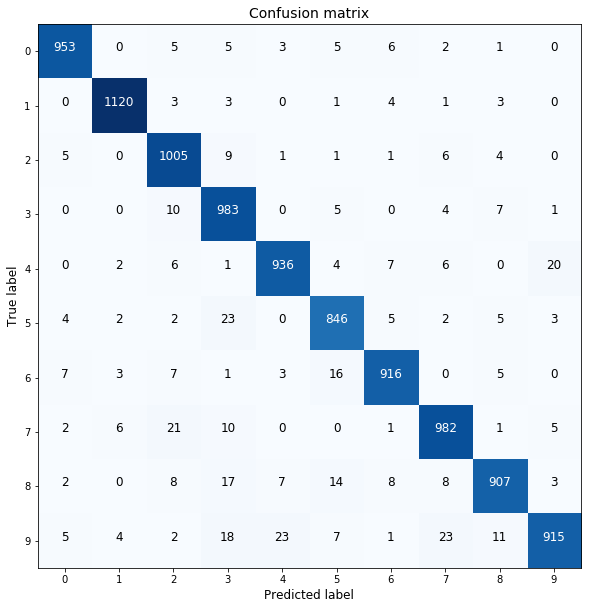

In [13]:
make_pretty_confusion_matrix(y_true, y_pred, classes)

In [14]:
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.97      0.97       980
          1       0.99      0.99      0.99      1135
          2       0.94      0.97      0.96      1032
          3       0.92      0.97      0.95      1010
          4       0.96      0.95      0.96       982
          5       0.94      0.95      0.94       892
          6       0.97      0.96      0.96       958
          7       0.95      0.96      0.95      1028
          8       0.96      0.93      0.95       974
          9       0.97      0.91      0.94      1009

avg / total       0.96      0.96      0.96     10000

